# Deteccion de Fruades

In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)

import math
from random import sample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew 
import os

## Carga de Datos

In [2]:
df = pd.read_csv("ds_challenge_data_2022.csv", encoding="utf-16")

In [3]:
df.shape

(26975, 16)

In [4]:
df.head(3)

,transaction_id,user_id,género,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",Farmacia,Ciudad de México,Aceptada,False,0.0,17.43,False
1,2,737,F,34000,51,421.73,02/01/20,0,"{'año': 2021, 'marca': 'Huawei', 'proveedor': ...",Tienda departamental,Cancún,Aceptada,False,0.0,12.65,False
2,3,887,F,52000,38,399.55,02/01/20,0,"{'año': 2017, 'marca': 'Apple', 'proveedor': '...",Farmacia,Tijuana,En proceso,False,0.0,11.99,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transaction_id   26975 non-null  int64  
 1   user_id          26975 non-null  int64  
 2   género           26975 non-null  object 
 3   linea_tc         26975 non-null  int64  
 4   interes_tc       26975 non-null  int64  
 5   monto            26975 non-null  float64
 6   fecha            26975 non-null  object 
 7   hora             26975 non-null  int64  
 8   dispositivo      26975 non-null  object 
 9   establecimiento  24036 non-null  object 
 10  ciudad           26641 non-null  object 
 11  status_txn       26975 non-null  object 
 12  is_prime         26975 non-null  bool   
 13  dcto             26975 non-null  float64
 14  cashback         26975 non-null  float64
 15  fraude           26975 non-null  bool   
dtypes: bool(2), float64(3), int64(5), object(6)
memory usage: 

In [6]:
df_clus = df.copy()

In [7]:
df.isna().sum() / df.shape[0]

transaction_id     0.000000
user_id            0.000000
género             0.000000
linea_tc           0.000000
interes_tc         0.000000
monto              0.000000
fecha              0.000000
hora               0.000000
dispositivo        0.000000
establecimiento    0.108953
ciudad             0.012382
status_txn         0.000000
is_prime           0.000000
dcto               0.000000
cashback           0.000000
fraude             0.000000
dtype: float64

<Axes: >

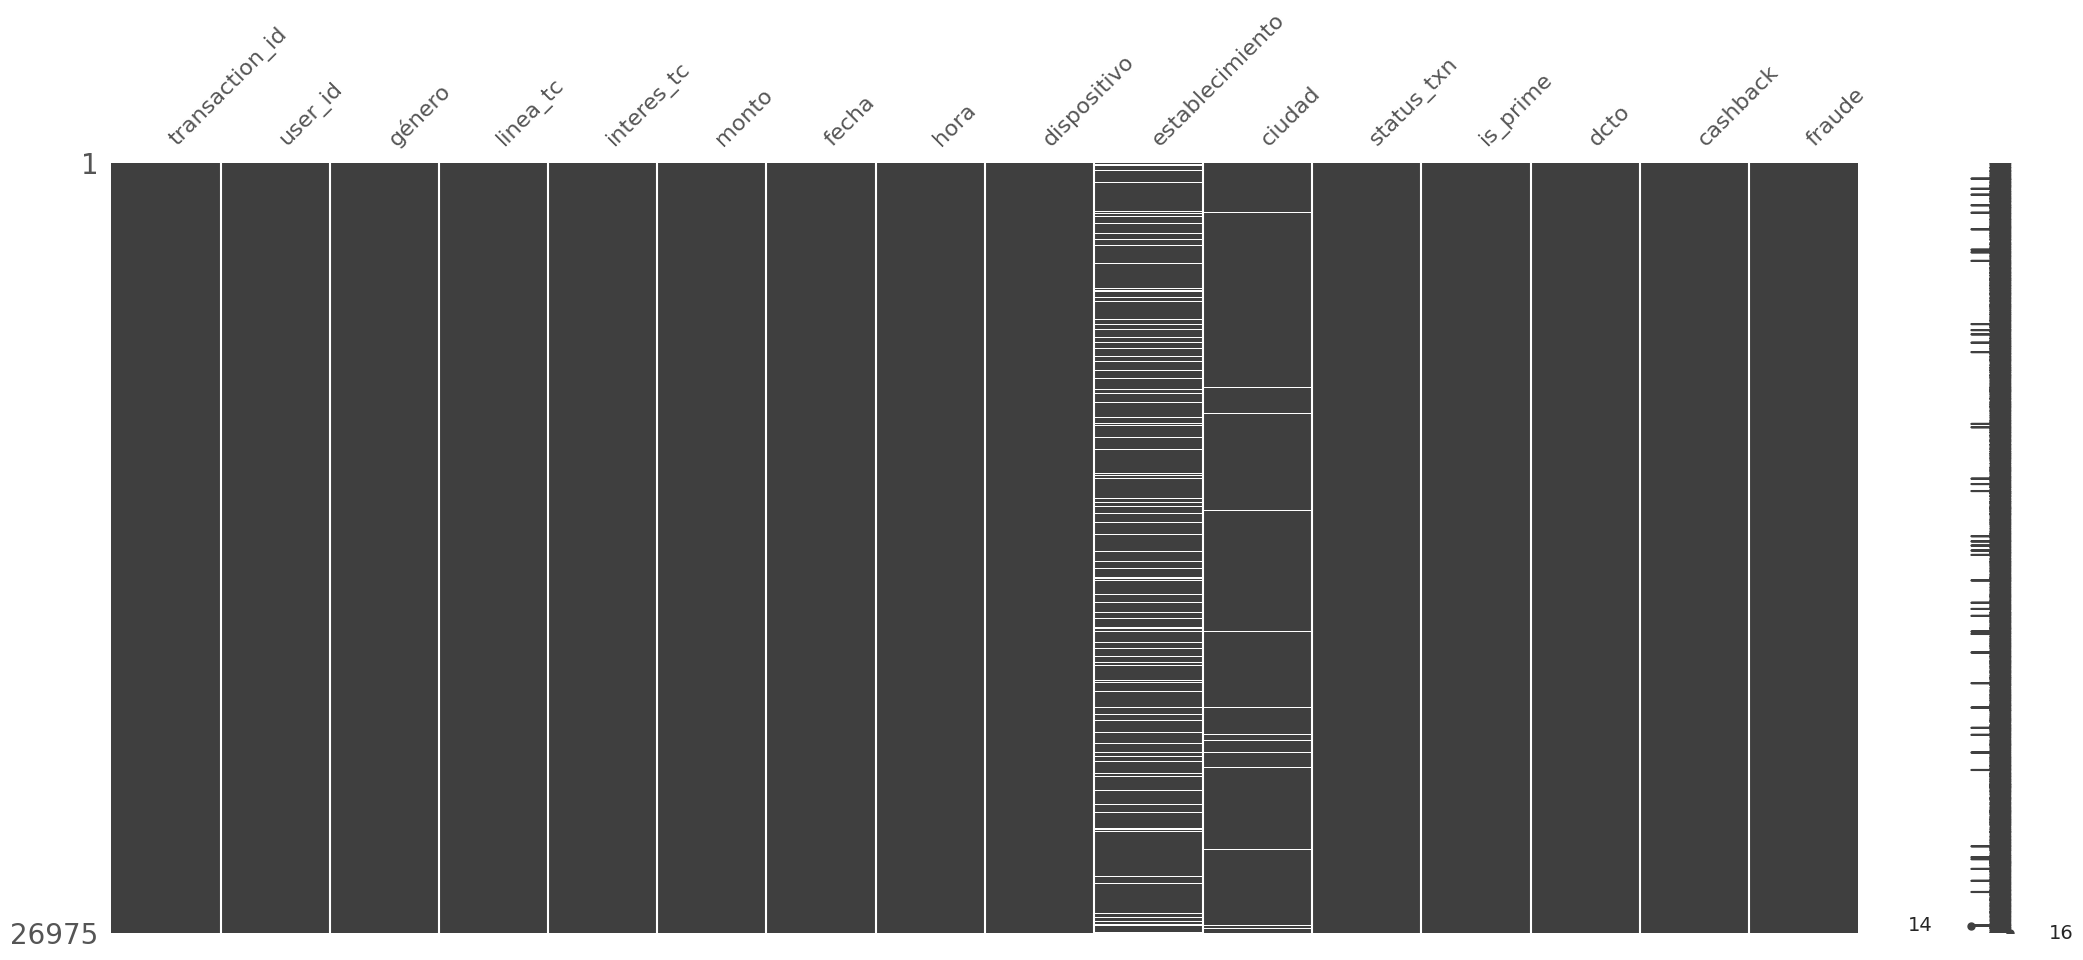

In [8]:
msno.matrix(df)

### Categorización de variables

In [9]:
df['dispositivo_split'] = df.dispositivo.map(lambda x : x.split(","))
df['dispositivo_anio'] = df['dispositivo_split'].map(lambda x: x[0].split(":")[1])
df['dispositivo_anio'] = df.dispositivo_anio.map(lambda x: x.replace(' ',''))
df['dispositivo_modelo'] = df['dispositivo_split'].map(lambda x: x[1].split(":")[1])
df['dispositivo_modelo'] = df.dispositivo_modelo.map(lambda x: x.replace(' ','').replace("'",''))
df['dispositivo_proveedor'] = df['dispositivo_split'].map(lambda x: x[2].split(":")[1])
df['dispositivo_proveedor'] = df.dispositivo_proveedor.map(lambda x: x.replace(' ','').replace("'",'').replace("}",''))
df = df.drop(columns=['dispositivo_split', 'dispositivo'])

In [10]:
id_feature = ['transaction_id', 'user_id']
categorical_feature = ['género', 'dispositivo_anio','dispositivo_modelo', 'dispositivo_proveedor', 'establecimiento', 'ciudad','status_txn', 'is_prime', 'fraude', 'hora']
continous_feature = ['linea_tc', 'interes_tc', 'monto', 'dcto', 'cashback']
time_feature = ['fecha']

## Analisis Exploratorio (EDA)

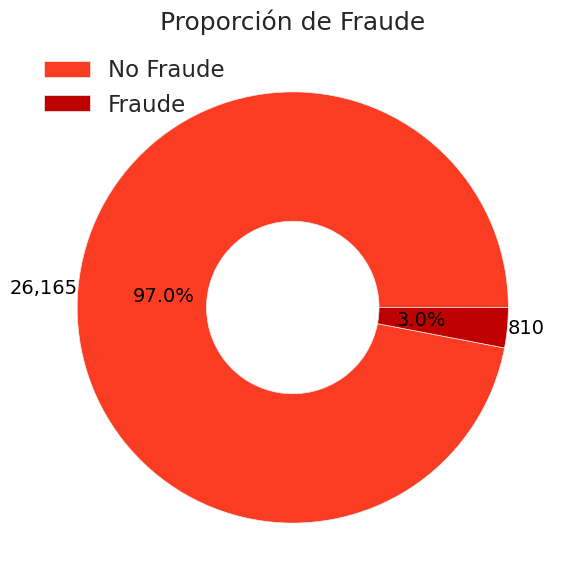

In [26]:
df1 = df.fraude.value_counts().reset_index()
df1['fraude'].replace({True : 'Fraude', False : 'No Fraude'}, inplace=True )
# Crear un gráfico de dona
plt.figure(figsize=(7, 7))  # Opcional: ajustar el tamaño del gráfico
plt.pie(df1['count'], labels=df1['count'].replace({26165 : '26,165', 810 : '810'}),autopct='%1.1f%%',
        wedgeprops=dict(width=0.6), textprops={'fontsize': 14, 'color': 'black'}, explode= (0, 0),
       labeldistance=1, colors=["#fa3d22", "#bf0000"])

labels = ["No Fraude", "Fraude"]

ax = plt.gca()  # Obtener el eje actual
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.legend(labels, loc="best", frameon=False)
# Personalizar el gráfico (opcional)
plt.title('Proporción de Fraude',fontsize=18)
plt.savefig("preuba.png", transparent = True)
# Mostrar el gráfico
plt.show()


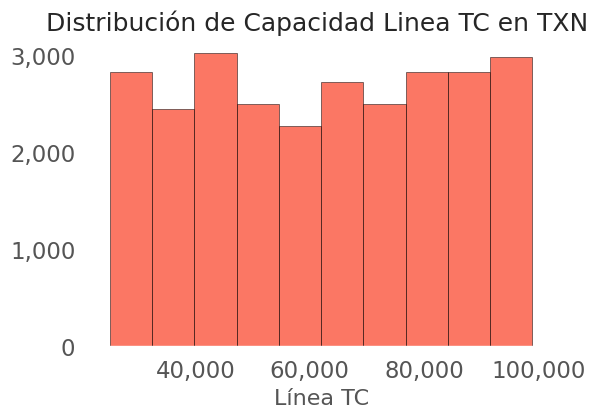

In [13]:
# Crear una figura con fondo blanco
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(6, 4), facecolor='white')

plt.hist(df["linea_tc"], bins=10, edgecolor='black', alpha=0.7, color="#fa3d22")

# Personalizar el histograma (opcional)
plt.title('Distribución de Capacidad Linea TC en TXN ',fontsize=18)
plt.xlabel('Línea TC', fontsize = 16)
# plt.ylabel('Línea TC', fontsize = 16)

# Personalizar el formato del eje x con comas
ax = plt.gca()  # Obtener el eje actual
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig("preuba.png", transparent = True)
# Mostrar el histograma
plt.show()


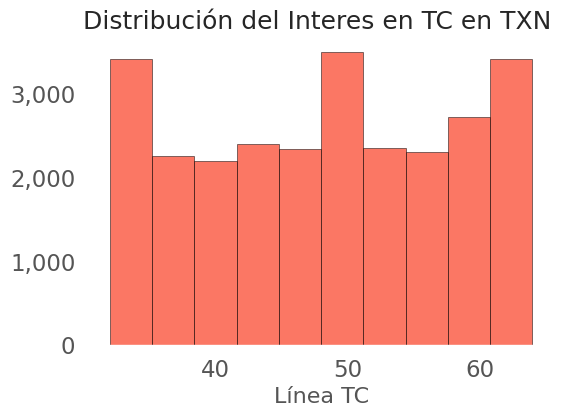

In [14]:
# Crear una figura con fondo blanco
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(6, 4), facecolor='white')

plt.hist(df["interes_tc"], bins=10, edgecolor='black', alpha=0.7, color="#fa3d22")

# Personalizar el histograma (opcional)
plt.title('Distribución del Interes en TC en TXN ',fontsize=18)
plt.xlabel('Línea TC', fontsize = 16)
# plt.ylabel('Línea TC', fontsize = 16)

# Personalizar el formato del eje x con comas
ax = plt.gca()  # Obtener el eje actual
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig("preuba.png", transparent = True)
# Mostrar el histograma
plt.show()


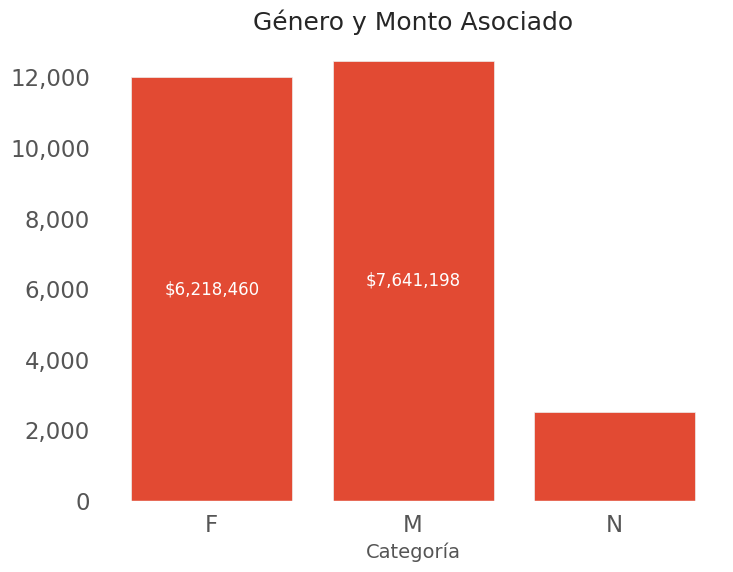

In [15]:
a = df.groupby('género').count()['user_id'].reset_index()
# Crear un gráfico de barras para la columna 'Valores'
plt.figure(figsize=(8, 6))  # Opcional: ajustar el tamaño del gráfico
bars = plt.bar(a['género'], a['user_id'])
montos = ['$6,218,460', '$7,641,198']

# Personalizar el gráfico (opcional)
plt.title('Género y Monto Asociado', fontsize = 18)
plt.xlabel('Categoría', fontsize = 14)
# plt.ylabel('Valores')

# Agregar etiquetas en la mitad de cada barra
for bar,e in zip(bars, montos):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(e),
             ha='center', va='center', fontsize=12, color='white')
    
ax = plt.gca()  # Obtener el eje actual
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig("preuba.png", transparent = True)
# Mostrar el gráfico
plt.show()

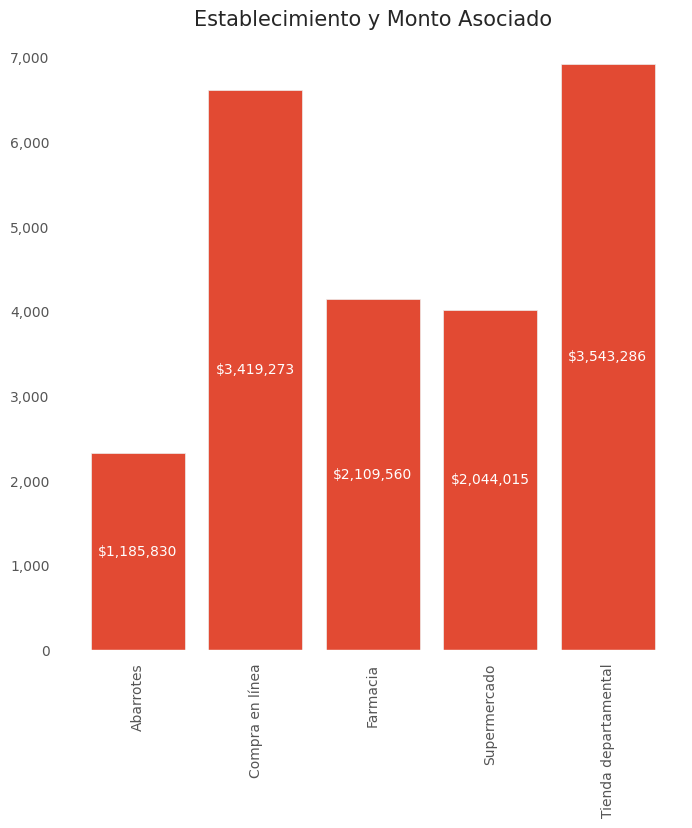

In [16]:
a = df.groupby('establecimiento').count()['user_id'].reset_index()
# Crear un gráfico de barras para la columna 'Valores'
plt.figure(figsize=(8, 8))  # Opcional: ajustar el tamaño del gráfico
bars = plt.bar(a['establecimiento'], a['user_id'])
montos = df.groupby('establecimiento').sum()['monto'].reset_index()['monto'].to_list()
montos = ['$'+"{:,}".format(int(x)) for x in montos]

# Personalizar el gráfico (opcional)
plt.title('Establecimiento y Monto Asociado', fontsize = 15)
# plt.xlabel('Categoría', fontsize = 24)
plt.xticks(rotation=90)
# plt.ylabel('Valores')

# Agregar etiquetas en la mitad de cada barra
for bar,e in zip(bars, montos):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(e),
             ha='center', va='center', fontsize=10, color='white')
    
ax = plt.gca()  # Obtener el eje actual
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis='both', labelsize=10)  
plt.savefig("preuba.png", transparent = True)
# Mostrar el gráfico
plt.show()

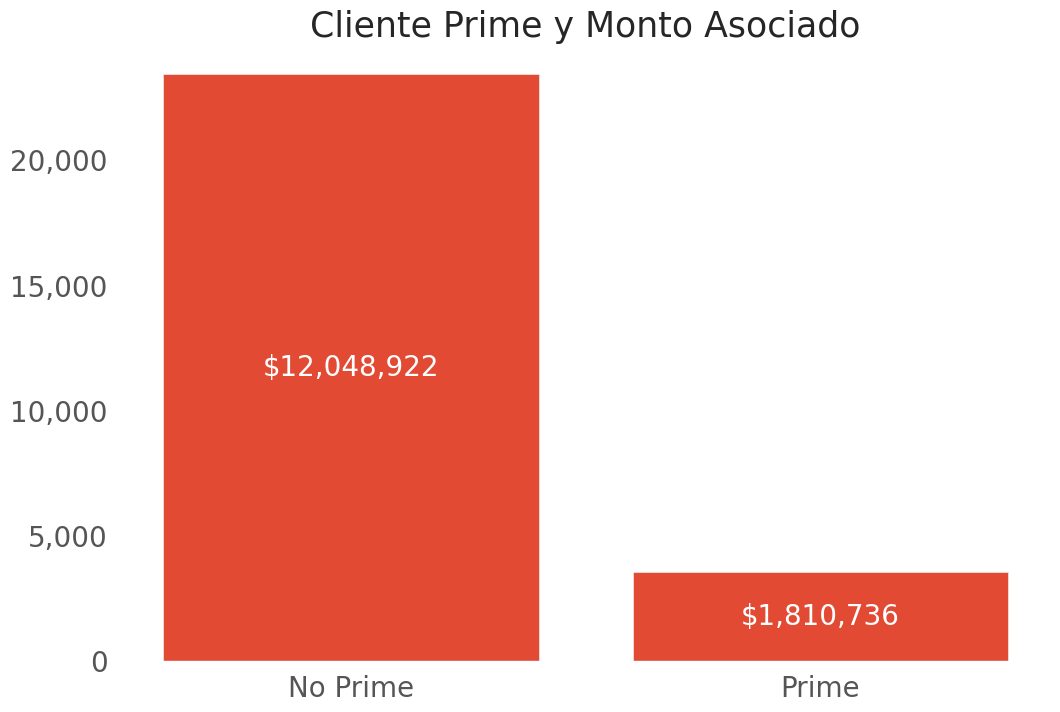

In [17]:
a = df.groupby('is_prime').count()['user_id'].reset_index()
# Crear un gráfico de barras para la columna 'Valores'
plt.figure(figsize=(12, 8))  # Opcional: ajustar el tamaño del gráfico
bars = plt.bar(a['is_prime'].replace({True:'Prime', False:'No Prime'}) , a['user_id'])
montos = df.groupby('is_prime').sum()['monto'].reset_index()['monto'].to_list()
montos = ['$'+"{:,}".format(int(x)) for x in montos]

# Personalizar el gráfico (opcional)
plt.title('Cliente Prime y Monto Asociado', fontsize = 25)
# plt.xlabel('Categoría', fontsize = 24)
# plt.xticks(rotation=90)
# plt.ylabel('Valores')

# Agregar etiquetas en la mitad de cada barra
for bar,e in zip(bars, montos):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(e),
             ha='center', va='center', fontsize=20, color='white')
    
ax = plt.gca()  # Obtener el eje actual
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis='both', labelsize=20)  
plt.savefig("preuba.png", transparent = True)
# Mostrar el gráfico
plt.show()

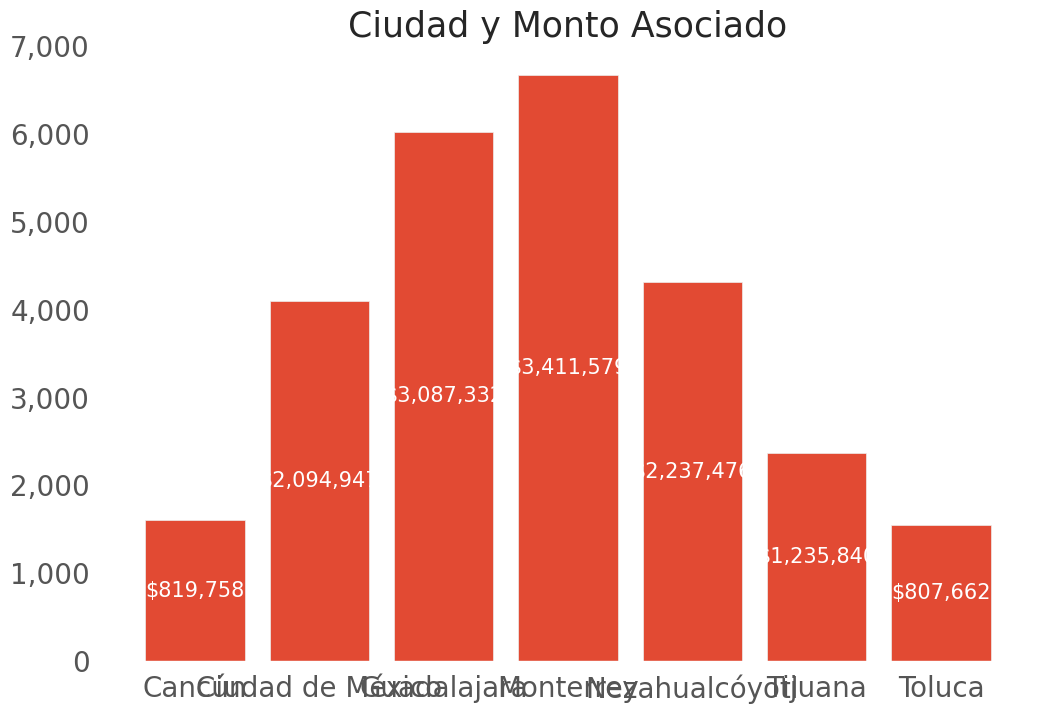

In [18]:
a = df.groupby('ciudad').count()['user_id'].reset_index()
# Crear un gráfico de barras para la columna 'Valores'
plt.figure(figsize=(12, 8))  # Opcional: ajustar el tamaño del gráfico
bars = plt.bar(a['ciudad'], a['user_id'])
montos = df.groupby('ciudad').sum()['monto'].reset_index()['monto'].to_list()
montos = ['$'+"{:,}".format(int(x)) for x in montos]

# Personalizar el gráfico (opcional)
plt.title('Ciudad y Monto Asociado', fontsize = 25)
# plt.xlabel('Categoría', fontsize = 24)
# plt.xticks(rotation=90)
# plt.ylabel('Valores')

# Agregar etiquetas en la mitad de cada barra
for bar,e in zip(bars, montos):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(e),
             ha='center', va='center', fontsize=15, color='white')
    
ax = plt.gca()  # Obtener el eje actual
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.tick_params(axis='both', labelsize=20)  
plt.savefig("preuba.png", transparent = True)
# Mostrar el gráfico
plt.show()

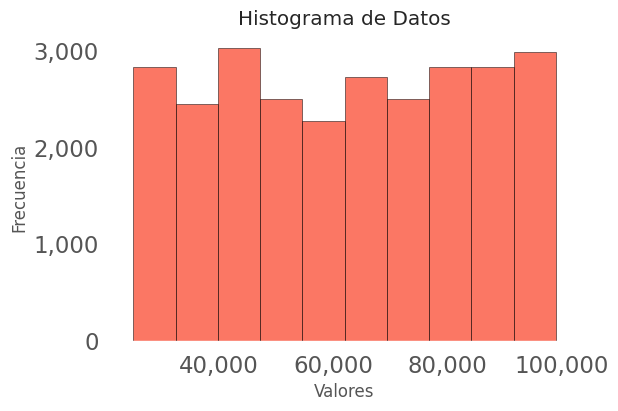

In [19]:
# Crear una figura con fondo blanco
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(6, 4), facecolor='white')

plt.hist(df["linea_tc"], bins=10, edgecolor='black', alpha=0.7, color="#fa3d22")

# Personalizar el histograma (opcional)
plt.title('Histograma de Datos')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Personalizar el formato del eje x con comas
ax = plt.gca()  # Obtener el eje actual
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig("preuba.png", transparent = True)
# Mostrar el histograma
plt.show()


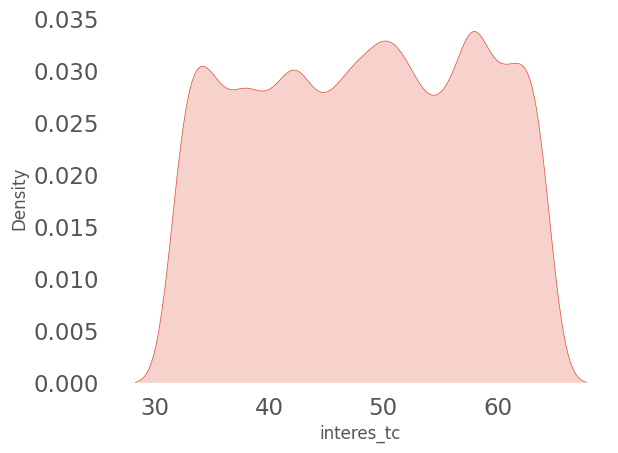

In [20]:
sns.kdeplot(df["interes_tc"], fill=True);

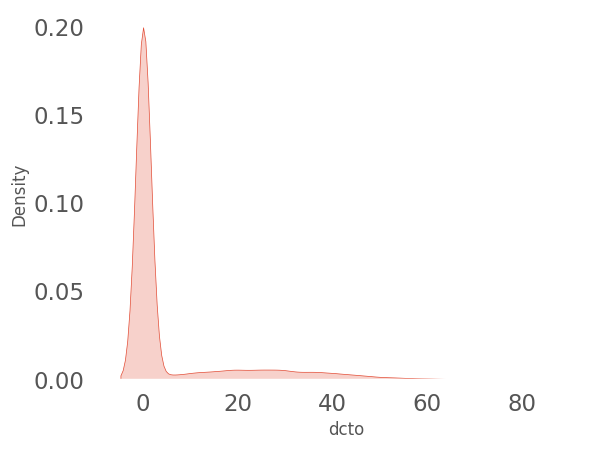

In [21]:
sns.kdeplot(df["dcto"], fill=True);

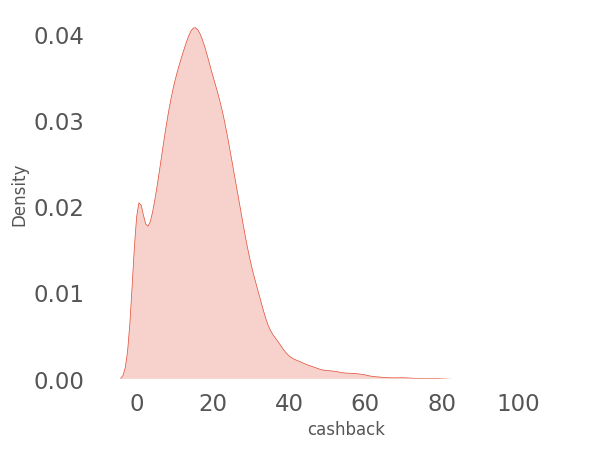

In [22]:
sns.kdeplot(df["cashback"], fill=True);

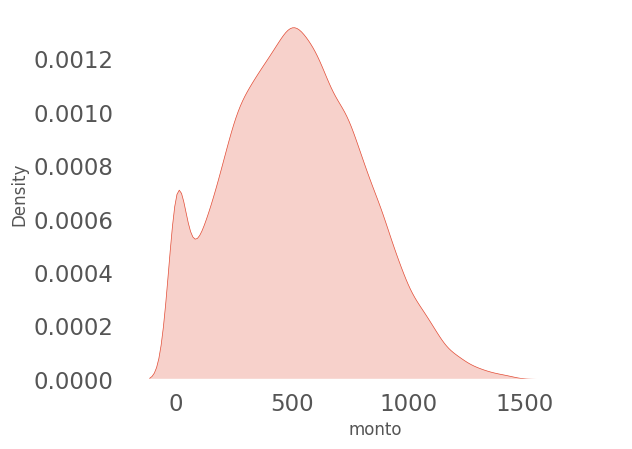

In [23]:
sns.kdeplot(df["monto"], fill=True);

<Axes: xlabel='cashback', ylabel='Probability'>

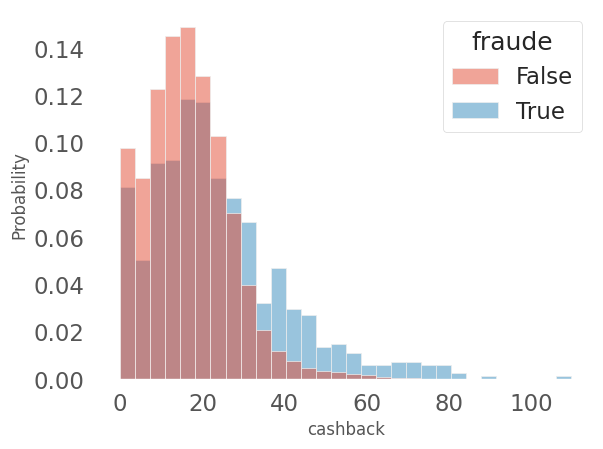

In [24]:
sns.histplot(x="cashback", hue="fraude", bins=30,stat="probability", data=df,common_norm=False)

<Axes: xlabel='hora', ylabel='Probability'>

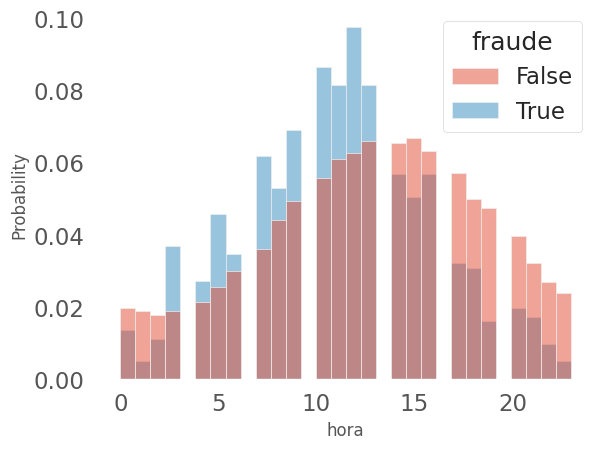

In [25]:
sns.histplot(x="hora", hue="fraude", bins=30,stat="probability", data=df,common_norm=False)

## Ingenieria de Variables

### Variables Categoricas    

In [27]:
df.hora.replace({0 : 'hasta_2hr', 1 : 'hasta_2hr', 2 : 'hasta_2hr', 3 : 'hasta_12hr', 4 : 'hasta_12hr', 5 : 'hasta_12hr', 6 : 'hasta_12hr', 7 : 'hasta_12hr', 8 : 'hasta_12hr', 9 : 'hasta_12hr', 10 : 'hasta_12hr', 11 : 'hasta_12hr', 12 : 'hasta_12hr', 13 : 'hasta_23hr', 14 : 'hasta_23hr', 15 : 'hasta_23hr', 16 : 'hasta_23hr', 17 : 'hasta_23hr', 18 : 'hasta_23hr', 19 : 'hasta_23hr', 20 : 'hasta_23hr', 21 : 'hasta_23hr', 22 : 'hasta_23hr', 23 : 'hasta_23hr'}, inplace=True)
df.género.replace({'N':'M'}, inplace=True)
df.establecimiento.replace({np.nan:'Desconocido', 'Abarrotes':'Supermercado'}, inplace=True)
df.ciudad.replace({'Nezahualcóyotl': 'Centro', 'Ciudad de México': 'Centro', 'Toluca': 'Centro', np.nan: 'Centro'}, inplace=True)
df.dispositivo_modelo.replace({'Samsung': 'Android', 'Motorola': 'Android', 'Huawei': 'Harmony', 'Apple': 'iOS'}, inplace=True)
df.dispositivo_anio.replace({'2011' : 'menor2018', '2012' : 'menor2018', '2013' : 'menor2018', '2014' : 'menor2018', '2015' : 'menor2018', '2016' : 'menor2018', '2017' : 'menor2018', '2018' : 'menor2018', '2019' : 'menor2022', '2020' : 'menor2022', '2021' : 'menor2022', '2022' : 'menor2022'}, inplace=True)

<Axes: >

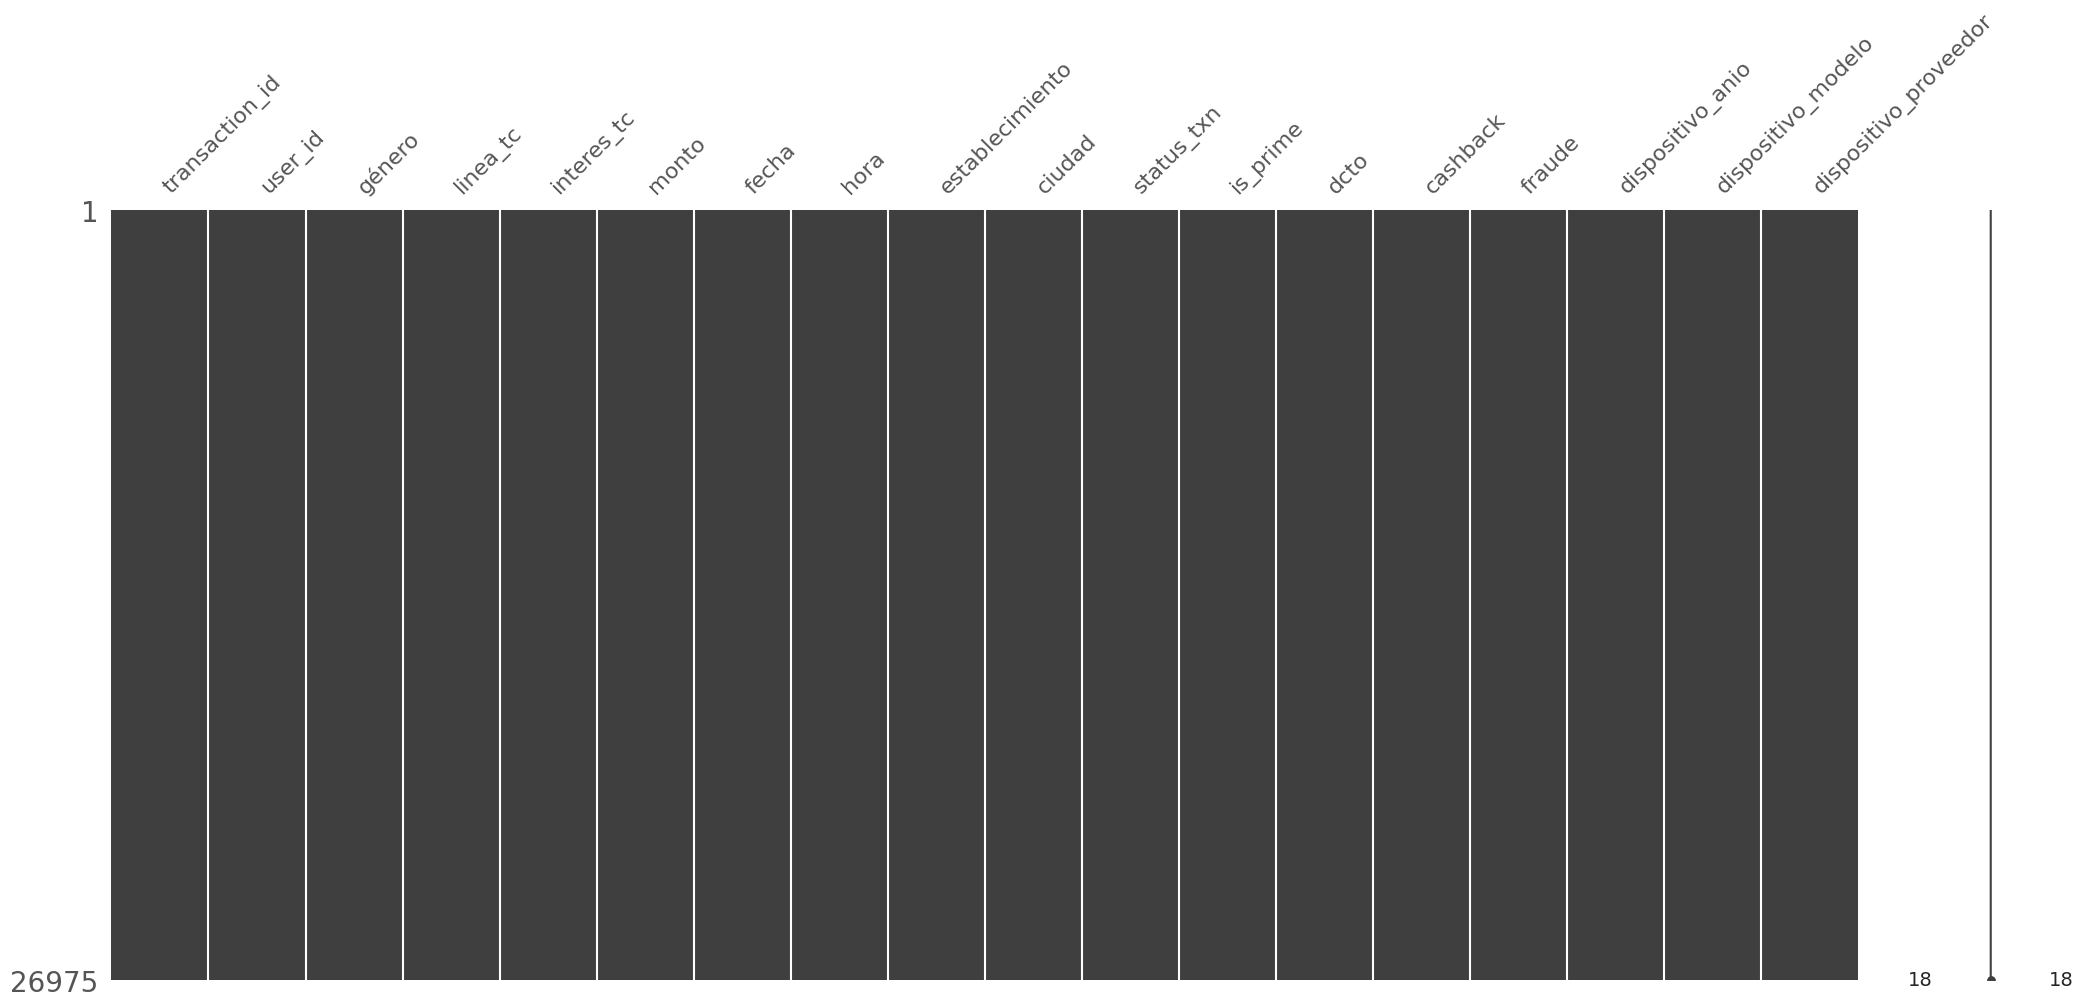

In [28]:
msno.matrix(df)

#### Transformacion a Dummys    

In [29]:
df_clus = pd.get_dummies(df, drop_first=False, columns=categorical_feature, dtype='int')

In [30]:
df = pd.get_dummies(df, drop_first=True, columns=categorical_feature, dtype='int')

### Variables Continuas

#### Creacion de Variables Artificiales

In [31]:
df["ratio_cm"] = df["cashback"] / df["monto"]
df["ratio_mltc"] = df["monto"] / df["linea_tc"]
df["ratio_mdesint"] = (df["monto"] * ( 1 - df["dcto"])) / df["interes_tc"]
df["ratio_mdesltc"] = (df["monto"] * ( 1 - df["dcto"])) / df["linea_tc"]
df["ratio_intltc"] = df["interes_tc"] / df["linea_tc"]
df["ratio_intmtoltc"] = df["interes_tc"] *df["monto"]  / df["linea_tc"]
df["interes_tc_log"] = np.log1p(df["interes_tc"])

#### Selección de Variables

In [32]:
col_drop =list(id_feature + time_feature)
col_drop.append('fraude_True')
col_drop.append('interes_tc')
col_drop.append('linea_tc')
col_drop

['transaction_id', 'user_id', 'fecha', 'fraude_True', 'interes_tc']

In [33]:
X = df.drop(columns=col_drop)
y = df['fraude_True']

#### Particionamiento de Datos

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [35]:
print(X_train.shape )
print(y_train.shape )
print(y_train.value_counts())
print(y_train.value_counts(1))
print(X_test.shape )
print(y_test.shape )
print(y_test.value_counts() )
print(y_test.value_counts(1) )
# y.shape

(21580, 30)
(21580,)
fraude_True
0    20932
1      648
Name: count, dtype: int64
fraude_True
0    0.969972
1    0.030028
Name: proportion, dtype: float64
(5395, 30)
(5395,)
fraude_True
0    5233
1     162
Name: count, dtype: int64
fraude_True
0    0.969972
1    0.030028
Name: proportion, dtype: float64


#### Remuestreo SMOTE - Tomek para clases desbalanceadas

In [36]:
# oversample = SMOTE(sampling_strategy = 0.55)
oversample = SMOTETomek(sampling_strategy = 0.70)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [37]:
print(y_train.value_counts(1))
print(y_test.value_counts(1))

fraude_True
0    0.597165
1    0.402835
Name: proportion, dtype: float64
fraude_True
0    0.969972
1    0.030028
Name: proportion, dtype: float64


#### Escalamiento y Estadarizacion de Variables

In [38]:
cf_mms = ['linea_tc', 'monto', 'dcto', 'cashback']
cf_stds = ['ratio_cm', 'ratio_mltc', 'ratio_mdesint', 'ratio_intltc', 'interes_tc_log', "ratio_mdesltc", "ratio_intmtoltc"]

In [39]:
mms = MinMaxScaler()
X_train[cf_mms] = mms.fit_transform(X_train[cf_mms])
X_test[cf_mms] = mms.transform(X_test[cf_mms])

In [40]:
sc = StandardScaler()
# X_train[cf_stds] = sc.fit_transform(X_train[['monto']]).flatten()
X_train[cf_stds] = sc.fit_transform(X_train[cf_stds])
X_test[cf_stds] = sc.transform(X_test[cf_stds])

In [41]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    print(classification_report(target,predicted))
    return None

### Modelado

#### Segmentacion (Aprendizaje No  Supervisado)

In [42]:
colmax = ['género_F', 'género_M', 'is_prime_False', 'is_prime_True']
df_colmax = df_clus.groupby('user_id')[colmax].max().reset_index()
df_colmax.head()

,user_id,género_F,género_M,is_prime_False,is_prime_True
0,0,0,1,1,0
1,1,1,0,1,0
2,2,0,1,1,0
3,3,0,1,1,0
4,4,0,1,1,0


In [43]:
colmean = ['monto','dcto', 'cashback']
df_colmean = df_clus.groupby('user_id')[colmean].mean().reset_index()
df_colmean.head()

,user_id,monto,dcto,cashback
0,0,392.655000,7.145000,11.780000
1,1,641.768571,5.301429,19.488571
2,2,548.381429,4.704286,17.151429
3,3,500.480000,16.060000,15.015000
4,4,254.010000,0.000000,7.620000


In [44]:
colcount = ['monto']
df_colcount = df.groupby('user_id')[colcount].count().reset_index()
df_colcount.head()

,user_id,monto
0,0,2
1,1,7
2,2,7
3,3,2
4,4,1


In [45]:
X_clus = pd.concat([df_colmax.drop(columns= 'user_id'), df_colcount.drop(columns= 'user_id'), df_colmean.drop(columns= 'user_id')], axis=1)
X_clus.head()

,género_F,género_M,is_prime_False,is_prime_True,monto,monto,dcto,cashback
0,0,1,1,0,2,392.655000,7.145000,11.780000
1,1,0,1,0,7,641.768571,5.301429,19.488571
2,0,1,1,0,7,548.381429,4.704286,17.151429
3,0,1,1,0,2,500.480000,16.060000,15.015000
4,0,1,1,0,1,254.010000,0.000000,7.620000


In [46]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_clus)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

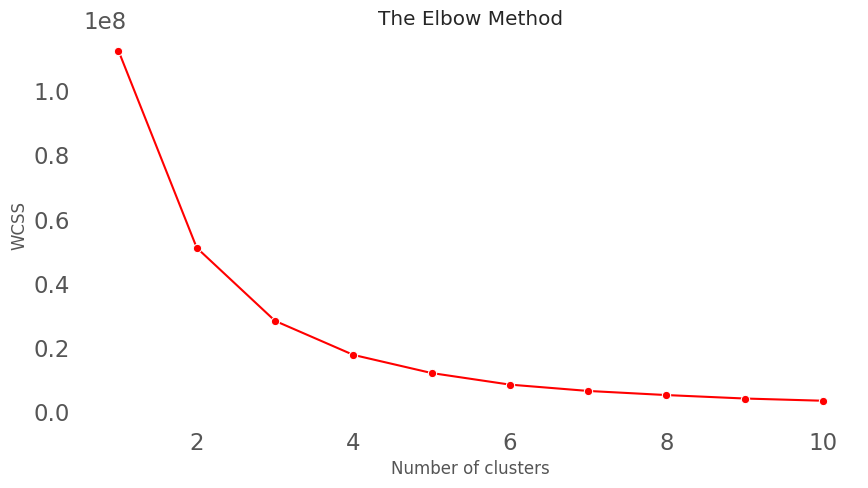

In [47]:
plt.figure(figsize=(10,5))
sns.lineplot(x = range(1, 11), y= wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [48]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_clus)

/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
dic_clus = {'cluster' :y_kmeans}
clus = pd.DataFrame(data = dic_clus)
df_c = pd.concat( [df_clus.groupby('user_id').count()['monto'].reset_index()['user_id'], clus], axis=1)

In [50]:
resultado = df_clus.merge(df_c, on='user_id', how='left')
resultado.head()

,transaction_id,user_id,linea_tc,interes_tc,monto,fecha,dcto,cashback,género_F,género_M,dispositivo_anio_menor2018,dispositivo_anio_menor2022,dispositivo_modelo_Android,dispositivo_modelo_Harmony,dispositivo_modelo_iOS,dispositivo_proveedor_ATT,dispositivo_proveedor_Movistar,dispositivo_proveedor_Telcel,establecimiento_Compra en línea,establecimiento_Desconocido,establecimiento_Farmacia,establecimiento_Supermercado,establecimiento_Tienda departamental,ciudad_Cancún,ciudad_Centro,ciudad_Guadalajara,ciudad_Monterrey,ciudad_Tijuana,status_txn_Aceptada,status_txn_En proceso,status_txn_Rechazada,is_prime_False,is_prime_True,fraude_False,fraude_True,hora_hasta_12hr,hora_hasta_23hr,hora_hasta_2hr,cluster
0,1,573,87000,56,581.03,02/01/20,0.0,17.43,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,3
1,2,737,34000,51,421.73,02/01/20,0.0,12.65,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,2
2,3,887,52000,38,399.55,02/01/20,0.0,11.99,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,2
3,4,1304,67000,60,828.01,02/01/20,0.0,24.84,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,3
4,5,1361,28000,52,886.04,02/01/20,0.0,26.58,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,3


In [51]:
resultado.drop(columns='fecha', inplace=True)

In [52]:
resultado.groupby('cluster').mean()[['monto', 'dcto', 'cashback']].reset_index()

,cluster,monto,dcto,cashback
0,0,816.706539,9.088974,27.111642
1,1,272.615541,3.125178,8.906531
2,2,459.307398,4.870339,15.148439
3,3,589.574860,6.009041,19.396728


In [53]:
resultado.groupby('cluster').nunique()['user_id'].reset_index()

,cluster,user_id
0,0,320
1,1,568
2,2,1585
3,3,1527


In [54]:
resultado.groupby('cluster').count()['user_id'].reset_index()

,cluster,user_id
0,0,731
1,1,1626
2,2,13010
3,3,11608


In [55]:
resultado.groupby('cluster').sum()[['is_prime_True']].reset_index()

,cluster,is_prime_True
0,0,101
1,1,219
2,2,1886
3,3,1353


In [56]:
# etiquetas = resultado.groupby('cluster').mean()[['monto', 'dcto', 'cashback']].reset_index()['cluster'].to_list()
etiquetas = resultado.groupby('cluster').mean()[['monto', 'dcto', 'cashback']].reset_index()['monto'].to_list()
etiquetas

[816.7065389876881, 272.61554120541206, 459.30739815526516, 589.5748604410752]

#### Deteccion de Fraude (Aprendizaje Supervisado)

* Instaciamos los objetos

In [58]:
rf = RandomForestClassifier(random_state=23)
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier(random_state=23)
lgbm = LGBMClassifier(random_state=23)
xgb = XGBClassifier()
knn = KNeighborsClassifier()
bbc = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(),
                                sampling_strategy='auto',
                                n_estimators= 30,
                                replacement=False,
                                random_state=0)

##### Random Forest

In [59]:
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_score_train = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_score_test = rf.predict_proba(X_test)[:,1]

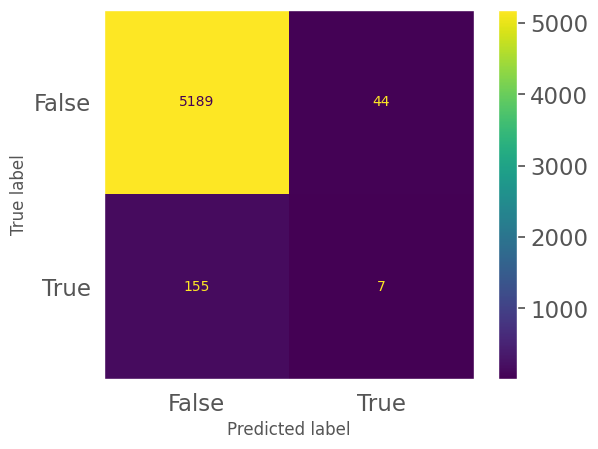

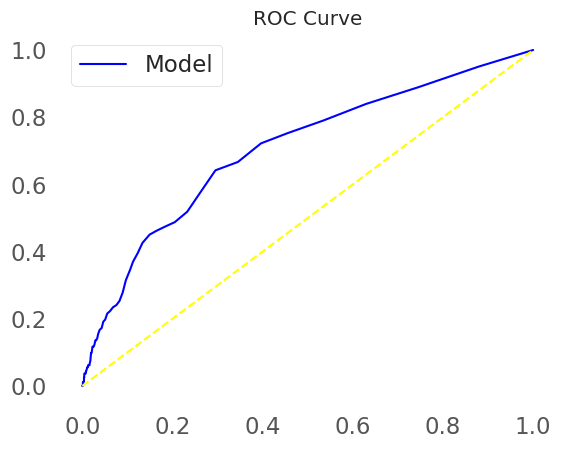

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5233
           1       0.14      0.04      0.07       162

    accuracy                           0.96      5395
   macro avg       0.55      0.52      0.52      5395
weighted avg       0.95      0.96      0.95      5395



In [60]:
evaluate_model(y_test, y_pred_test, y_score_test)

##### LGBM

In [61]:
lgbm.fit(X_train, y_train)

y_pred_train = lgbm.predict(X_train)
y_score_train = lgbm.predict_proba(X_train)[:,1]

y_pred_test = lgbm.predict(X_test)
y_score_test = lgbm.predict_proba(X_test)[:,1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13018, number of negative: 19298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2843
[LightGBM] [Info] Number of data points in the train set: 32316, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402835 -> initscore=-0.393668
[LightGBM] [Info] Start training from score -0.393668


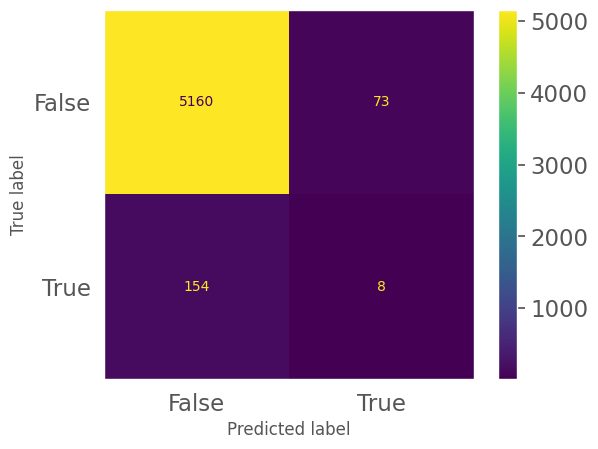

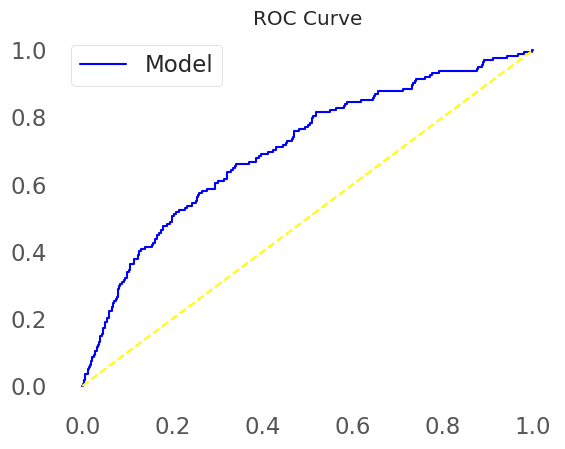

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5233
           1       0.10      0.05      0.07       162

    accuracy                           0.96      5395
   macro avg       0.53      0.52      0.52      5395
weighted avg       0.94      0.96      0.95      5395



In [62]:
evaluate_model(y_test, y_pred_test, y_score_test)

##### Gradient Boosting

In [63]:
gboost.fit(X_train, y_train)

y_pred_train = gboost.predict(X_train)
y_score_train = gboost.predict_proba(X_train)[:,1]

y_pred_test = gboost.predict(X_test)
y_score_test = gboost.predict_proba(X_test)[:,1]

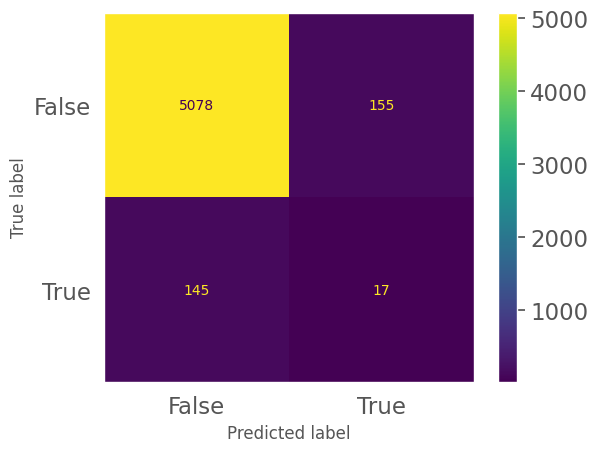

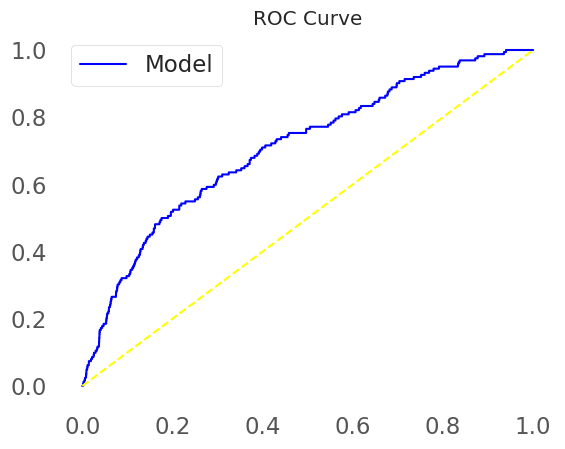

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5233
           1       0.10      0.10      0.10       162

    accuracy                           0.94      5395
   macro avg       0.54      0.54      0.54      5395
weighted avg       0.95      0.94      0.95      5395



In [64]:
evaluate_model(y_test, y_pred_test, y_score_test)

##### XGBoost

In [65]:
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
y_score_train = xgb.predict_proba(X_train)[:,1]

y_pred_test = xgb.predict(X_test)
y_score_test = xgb.predict_proba(X_test)[:,1]

/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is

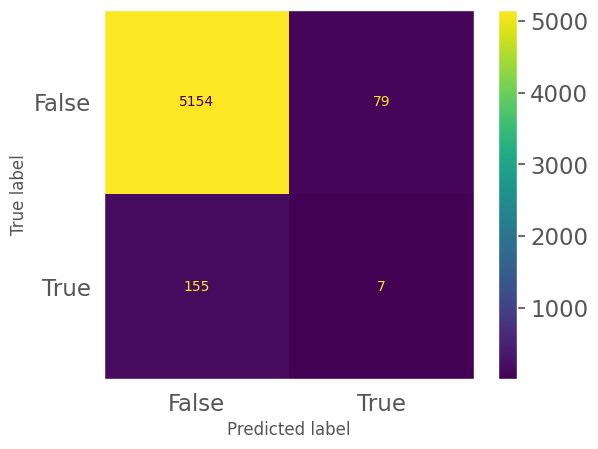

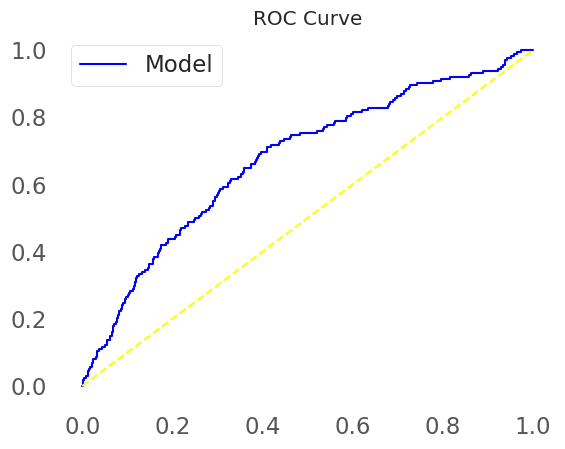

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5233
           1       0.08      0.04      0.06       162

    accuracy                           0.96      5395
   macro avg       0.53      0.51      0.52      5395
weighted avg       0.94      0.96      0.95      5395



In [66]:
evaluate_model(y_test, y_pred_test, y_score_test)

##### K-Nearest Neighbors

In [67]:
knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_score_train = knn.predict_proba(X_train)[:,1]

y_pred_test = knn.predict(X_test)
y_score_test = knn.predict_proba(X_test)[:,1]

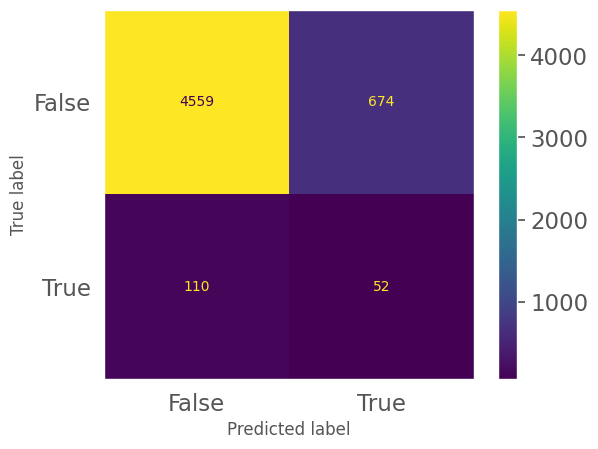

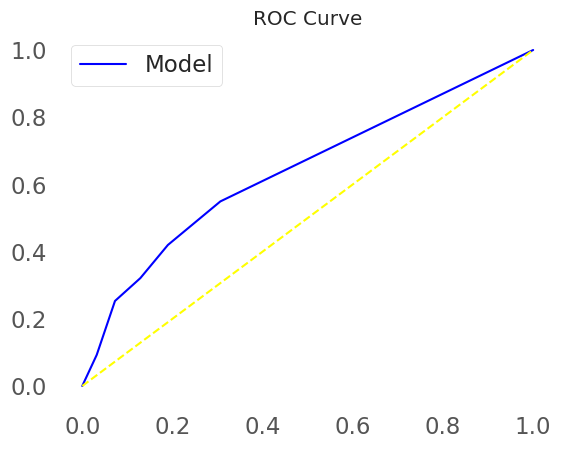

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5233
           1       0.07      0.32      0.12       162

    accuracy                           0.85      5395
   macro avg       0.52      0.60      0.52      5395
weighted avg       0.95      0.85      0.90      5395



In [68]:
evaluate_model(y_test, y_pred_test, y_score_test)

##### Balanced Bagging Classifier con estimador K-Nearest Neighbors

In [69]:
bbc.fit(X_train, y_train)

y_pred_train = bbc.predict(X_train)
y_score_train = bbc.predict_proba(X_train)[:,1]

y_pred_test = bbc.predict(X_test)
y_score_test = bbc.predict_proba(X_test)[:,1]

/home/etellu/jupyter/jupyter/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


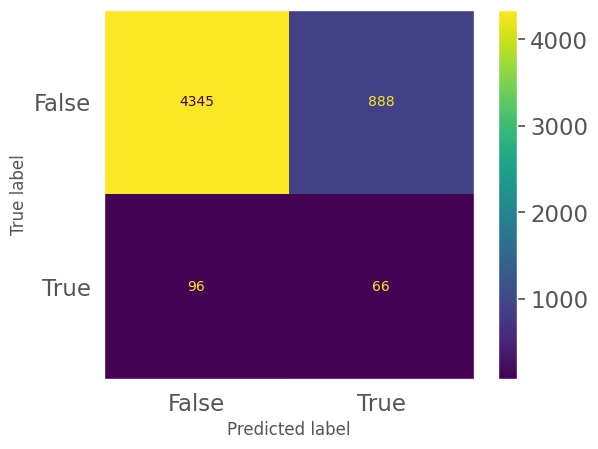

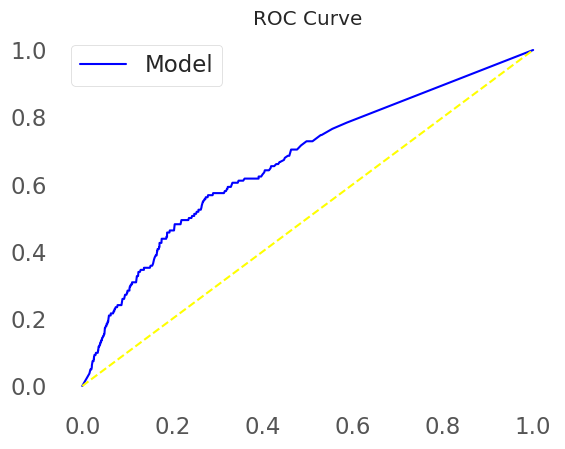

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      5233
           1       0.07      0.41      0.12       162

    accuracy                           0.82      5395
   macro avg       0.52      0.62      0.51      5395
weighted avg       0.95      0.82      0.87      5395



In [70]:
evaluate_model(y_test, y_pred_test, y_score_test)

In [71]:
df[df.fraude_True == 1]["monto"].sum()

468956.2

In [73]:
df[df.fraude_True == 1]["monto"].sum() * 0.41

192272.042